## Metropolis Algorithm
```
Metropolis, N., Rosenbluth, A. W., Rosenbluth, M. N., Teller, A. H., & Teller, E. (1953). Equation of state calculations by fast computing machines. The journal of chemical physics, 21(6), 1087-1092.
```
The Metropolis algorithm is an instance of the MCMC class of algorithms, with the purpose of sampling from a posterior distribution that may be intractable to manipulate analytically.

Let's start with a simple example:
 - Suppose you want to find the posterior distribution over the bias $\theta$ of a coin, given
a list of $n$ observations $X_i$. 
 - We start with a uniform prior: $\theta \sim \mathsf{Uniform}(0,1)$, and consider the binomial likelihood: $X \mid \theta \sim \mathsf{Binomial}(n, \theta)$.
 - The posterior will be $p(\theta \mid X) = \dfrac{p(X\mid\theta) \cdot p(\theta)}{Z_p}$, where $Z_p=\int_0^1{p(X\mid\theta) \cdot p(\theta) d\theta}$ is the normalising constant.

Let's assume that $Z_p$ is "intractable", so we will use the Metropolis algorithm to sample from the posterior. 

First, we need a **symmetric proposal distribution**, that will give us a new potential sample to move to. Next, the acceptance probability of moving to a new sample $\theta^\star$ given the current sample $\theta_t$ is 
$$
\min\left(1, \ \dfrac{p(\theta^\star \mid X)}{p(\theta_t \mid X)}\right) = \min\left(1, \ \dfrac{p(X\mid\theta^\star)\cdot p(\theta^\star)}{p(X\mid\theta_t)\cdot p(\theta_t)}\right)
$$
which can now be evaluated, since the likelihood and the prior are known.

In [1]:
import numpy as np
import scipy.stats as stats
from sympy import integrate, symbols

from collections import namedtuple
from tqdm import trange
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

In [2]:
Observation = namedtuple('Observation', ['n', 'k'])

obs = Observation(n=20, k=17)

def ground_truth_density(obs):
    """Computes the actual posterior density f(θ | X).
    observation 
        (n, k)
    prior 
        θ ~ uniform(0,1)
        f(θ) = 1
    likelihood
        X | θ ~ binom(n, θ).pmf(k)
        f(X | θ) = (n k) * (θ**k) * (1-θ)**(n-k)
    normalising constant
        Z = int(0,1) likelihood * prior dθ
        Z = int(0,1) (θ**k) * (1-θ)**(n-k) dθ
        (n k) cancels with the (n k) from the numerator
    """
    n, k = obs.n, obs.k
    x = symbols('x')
    
    Z = integrate(f"x**{k} * (1-x)**{n-k}", (x, 0, 1))
    Z = float(Z.evalf())
    
    def inner(θ):
        return θ**k * (1-θ)**(n-k) / Z
    
    return inner

In [3]:
def prior(theta):
    return stats.uniform(0, 1).pdf(theta)

def likelihood(obs: Observation, theta: float):
    if not (0 <= theta <= 1):
        return 0
    return stats.binom(n=obs.n, p=theta).pmf(obs.k)

def proposal(cur_theta: float, step_size: float):
    return stats.norm(loc=cur_theta, scale=step_size).rvs()

def metropolis(num_iters: int, step_size: float) -> np.array:
    """
    Notes:
        * (likelihood x prior) is usually expressed as a single function (the unnormalised posterior)
        * the accepted probability can be expressed in terms of log, for numerical stability
    """
    theta = 0
    samples = np.zeros(num_iters)
    
    for t in trange(num_iters, desc='Running Metropolis sampling'):
        # propose a new theta
        theta_new = proposal(theta, step_size=step_size)
        
        ratio_top = likelihood(obs, theta_new) * prior(theta_new)
        ratio_bot = likelihood(obs, theta) * prior(theta)
            
        if np.isclose(ratio_top, 0):
            acc_prob = 0
        elif ratio_top > ratio_bot:
            acc_prob = 1
        else:
            acc_prob = min(1, ratio_top / ratio_bot)
        
        u = np.random.uniform()
        if u < acc_prob:
            theta = theta_new
        
        samples[t] = theta
    
    return samples

In [4]:
posterior = metropolis(num_iters=50_000, step_size=0.5)

Running Metropolis sampling: 100%|█████████████████████████████████████████████| 50000/50000 [02:27<00:00, 338.95it/s]


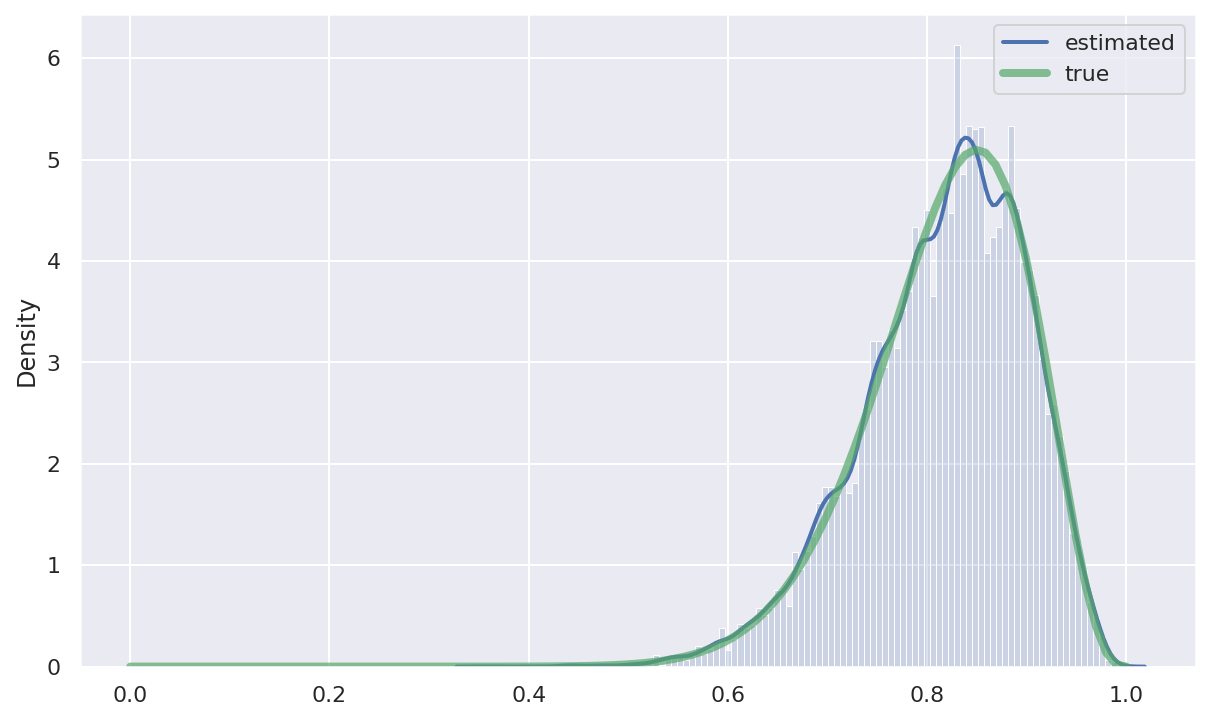

In [5]:
plt.figure(figsize=(10, 6))

sns.histplot(posterior, stat='density', alpha=0.2)
sns.kdeplot(posterior, color='b', lw=2, label='estimated')

post = ground_truth_density(obs)
xs = np.linspace(0, 1, 100)
plt.plot(xs, [post(x) for x in xs], c='g', lw=4, alpha=0.7, label='true')

plt.legend()
pass

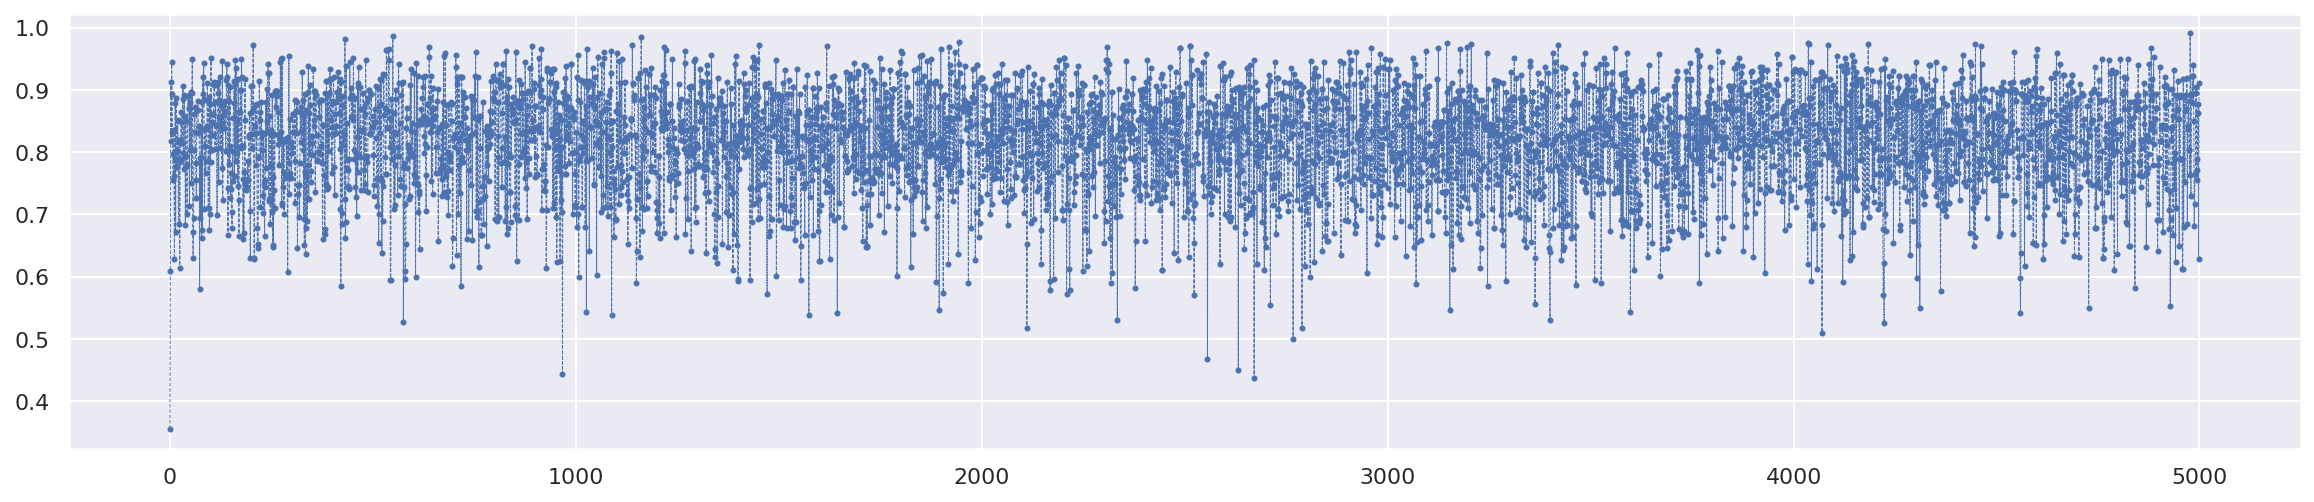

In [6]:
plt.figure(figsize=(20,4))
plt.plot(posterior[::10], linestyle='--', marker='o', lw=0.5, markersize=2)